In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, interp2d, UnivariateSpline, griddata
from scipy.optimize import least_squares, curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Times New Roman + SimSun + WFM Sans SC']
plt.rcParams['mathtext.fontset']='stix'
# Times New Roman + SimSun + WFM Sans SC
# simsum宋体, times new roman -*, simhei黑体, kaiti楷体, 
# dengxian等线, fangsong仿宋, Microsoft Yahei微软雅黑
plt.rcParams['axes.unicode_minus']=False   
plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = [4, 3]
# plt.rcParams['font.size'] = 12
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

### 1
一维插值，求积分

I    = 2.2430228027412946
Ihat = 2.243001128645944


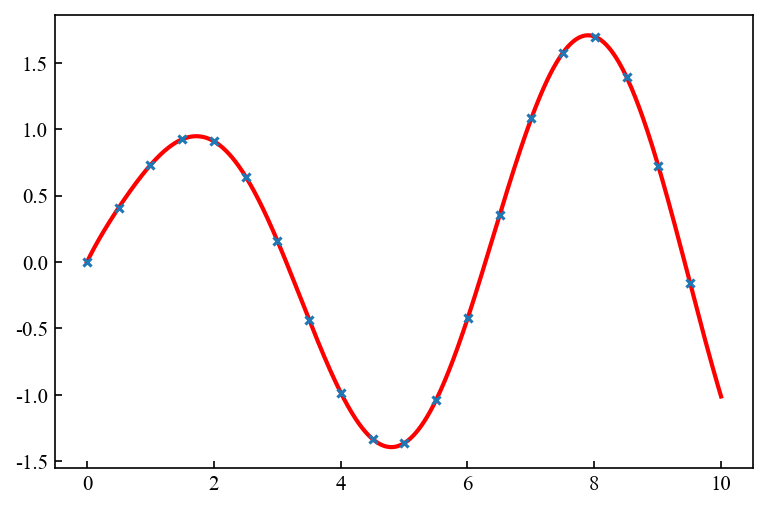

In [2]:
x0 = np.linspace(0, 10, 1000)
g = lambda x: (3*x**2+4*x+6)*np.sin(x) / (x**2+8*x+6)
y0 = g(x0)
ghat = interp1d(x0, y0)
yhat = ghat(x0)
I = quad(g, 0, 10)[0]
Ihat = np.trapz(yhat, x0)
print(f'{I    = }\n{Ihat = }')

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.scatter(x0[::50], y0[::50], s=15, marker='x', zorder=10)
ax.plot(x0, yhat, linewidth=2, color='r')
fig.show()

### 2
二维插值，求表面积

In [3]:
z0 = pd.read_excel('../../../hw/07第7章  插值与拟合习题解答/附件1：区域高程数据.xlsx', header=None, nrows=874).values.T

In [4]:
from numpy.linalg import norm

n, m = z0.shape # 已调整为列 x行 y
x0 = np.arange(0, m*50, 50)
y0 = np.arange(0, n*50, 50)
f = interp2d(x0, y0, z0, 'cubic')    # 双线性插值

x = np.arange(0, m*50+25, 25)
y = np.arange(0, n*50+25, 25)
z = f(x, y)

In [5]:
# 用分片线性插值的思想、海伦公式求表面积
m, n = len(x), len(y)
S = 0
for i in np.arange(m-1):
    for j in np.arange(n-1):
        p1 = np.array([x[i], y[j], z[j,i]])
        p2 = np.array([x[i+1], y[j], z[j,i+1]])
        p3 = np.array([x[i+1], y[j+1], z[j+1,i+1]]) # p1, p3为对角
        p4 = np.array([x[i], y[j+1], z[j+1,i]])
        d12 = norm(p1 - p2)
        d23 = norm(p2 - p3)
        d34 = norm(p3 - p4)
        d14 = norm(p1 - p4)
        d13 = norm(p1 - p3)
        P1 = (d12 + d23 + d13)/2
        S1 = np.sqrt(P1*(P1-d12)*(P1-d23)*(P1-d13))
        P2 = (d14 + d34 + d13)/2
        S2 = np.sqrt(P2*(P2-d14)*(P2-d34)*(P2-d13))
        S += S1 + S2

print("区域面积为：", S)

区域面积为： 2581392868.949955


### 3
一维插值

线性插值的预测结果为： [0.14785 0.16075]
三次样条插值的预测结果为： [0.14832031 0.16107969]


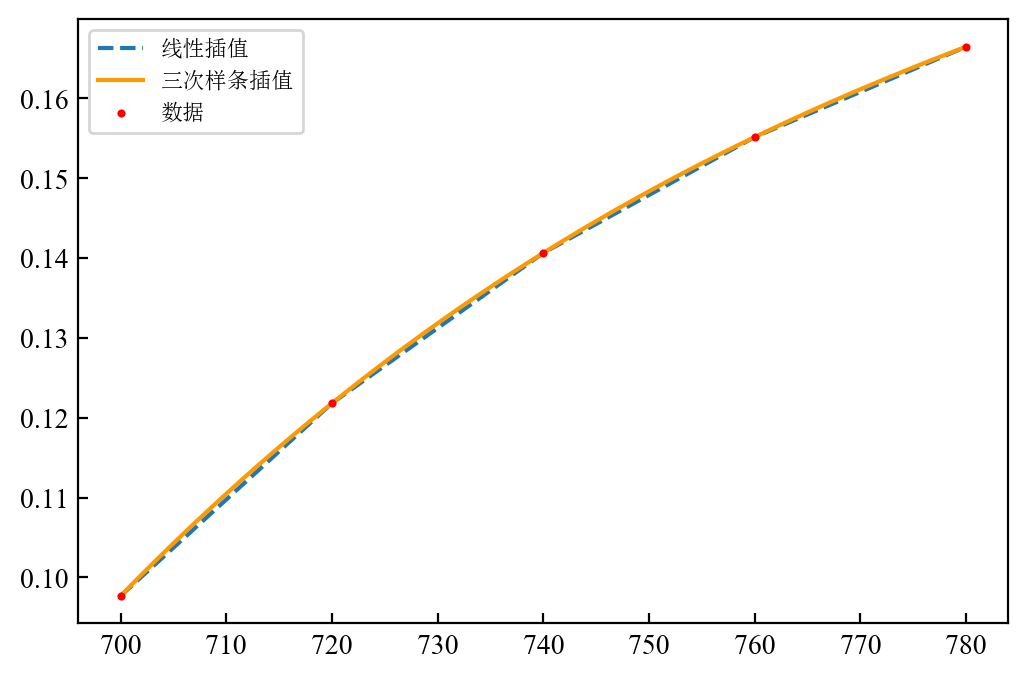

In [6]:
t0 = np.linspace(700, 780, 5)
v0 = np.array([0.0977, 0.1218, 0.1406, 0.1551, 0.1664])
f1 = interp1d(t0, v0)
f2 = interp1d(t0, v0, 'cubic')

tp = np.array([750, 770])
vp1 = f1(tp)
vp2 = f2(tp)
print("线性插值的预测结果为：", vp1)
print("三次样条插值的预测结果为：", vp2)

t = np.linspace(700, 780, 200)
v1 = f1(t)
v2 = f2(t)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, v1, '--', label='线性插值')
ax.plot(t, v2, '-', label='三次样条插值', color='#ff9900')
ax.scatter(t0, v0, label='数据', zorder=10, marker='.', s=15, color='r')
ax.legend(fontsize=8)
fig.show()

### 4
散乱数据插值

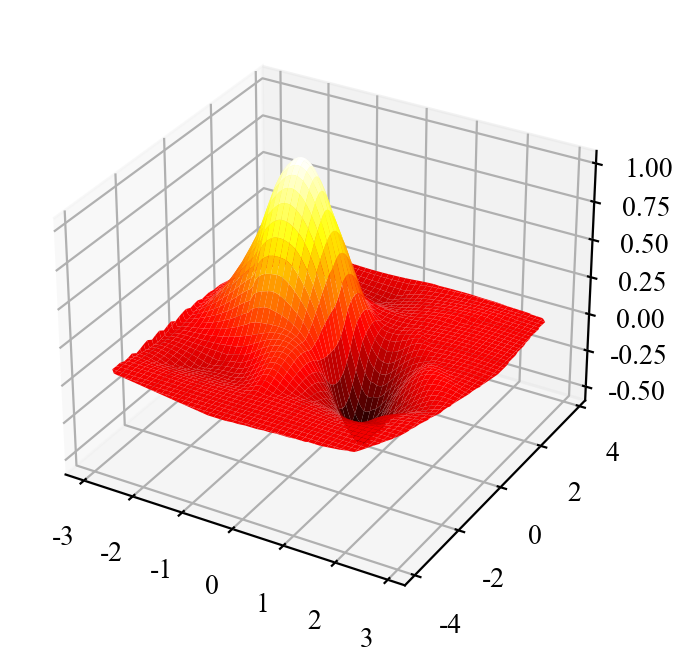

In [7]:
np.random.seed(114514)

x0 = np.random.uniform(-3, 3, 50)
y0 = np.random.uniform(-4, 4, 50)
f = lambda x, y: (x**2 - 2*x)*np.exp(-x**2 - y**2 - x*y)
z0 = f(x0, y0)

xy0 = np.vstack([x0, y0]).T
x = np.linspace(x0.min(), x0.max(), 300)
y = np.linspace(y0.min(), y0.max(), 300)
X, Y = np.meshgrid(x, y)
z = griddata(xy0, z0, (X,Y), 'cubic')
zl = griddata(xy0, z0, (X,Y), 'linear')
z[np.isnan(z)] = zl[np.isnan(z)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z, cmap='hot')
fig.show()

### 5
最小二乘线性拟合

In [8]:
p0, t0 = np.loadtxt('../../../hw/07第7章  插值与拟合习题解答/ti7_5.txt')
a, b = np.polyfit(p0, t0, 1)
print(f'{a = }\n{b = }')

a = 2.233700151626497
b = 95.35241997748852


### 6
有噪声的拟合

In [9]:
A = np.array([8, 5, 2, -1])
x0 = np.linspace(-6, 6, 100)
y0 = np.polyval(A, x0)
A1 = np.polyfit(x0, y0, 3)

ynoise = y0 + 0.2*np.random.randn(len(y0))
A2 = np.polyfit(x0, ynoise, 3)

print("无噪声时的拟合系数：", A1) 
print("有噪声时的拟合系数：", A2)

无噪声时的拟合系数： [ 8.  5.  2. -1.]
有噪声时的拟合系数： [ 7.99841048  5.00259286  2.02880128 -1.04883727]


### 7
最小二乘拟合

In [10]:
# x：独立变量 (x, y, ...)
# u：待拟合参数 (mu1, mu2, s, ...)
# y：原始函数值

def func(u, x):    # 待拟合模型
    return (10*u[0]) / (10*u[1] + (u[0]-10*u[1])*np.exp(-u[0]*np.sin(x)))

def err(u, x, y):   # 误差函数
    return func(u, x) - y

x0 = np.arange(1, 21, 1)
a, b = 1.1, 0.01
y0 = func([a, b], x0)

np.random.seed(2)
u = np.random.rand(2)
A1 = least_squares(err, u, args=(x0, y0))['x']

g = lambda x, a, b: 10*a / (10*b + (a-10*b)*np.exp(-a*np.sin(x)))
A2 = curve_fit(g, x0, y0, p0=u)[0]

print("least_squares()的拟合系数：", A1)
print("curve_fit()的拟合系数：", A2)

least_squares()的拟合系数： [1.1  0.01]
curve_fit()的拟合系数： [1.1  0.01]


### 8
最小二乘拟合

In [11]:
data = np.loadtxt('../../../hw/07第7章  插值与拟合习题解答/ti7_8.txt')
t0 = data[::2].flatten()
y0 = data[1::2].flatten()

def func(u, x):
    beta1, beta2, lambda1, lambda2 = u
    return beta1*np.exp(-lambda1*x) + beta2*np.exp(-lambda2*x)

def err(u, x, y):
    return func(u, x) - y

u = np.random.rand(4)
beta1, beta2, lambda1, lambda2 = least_squares(err, u, args=(t0, y0))['x']
print(f'{beta1 = }\n{beta2 = }\n{lambda1 = }\n{lambda2 = }')

beta1 = 3.0229401144211643
beta2 = 2.8725990845307225
lambda1 = 10.50900808826282
lambda2 = 1.3911091592721812


### 9
最小二乘拟合

In [12]:
def func(u, x):
    return (u[0]*x[0]*x[1]) / (1 + u[1]*np.sin(x[0]))

def err(u, x, y):
    return func(u, x) - y

x0 = np.linspace(-6, 6, 30)
y0 = np.linspace(-8, 8, 30)

xy0 = np.array([x0, y0])
X , Y = np.meshgrid(x0, y0)
x0, y0 = X.flatten(), Y.flatten()
a0, b0 = 2, 3
u0 = np.array([a0, b0])
z0 = func(u0, xy0)

u = np.random.rand(2)

a, b = least_squares(err, u, args=(xy0, z0))['x']
print(f'{a = }\n{b = }')

a = 1.3471834076151759
b = -0.10920338608987365


In [13]:
x0 = np.linspace(-6, 6, 30)
y0 = np.linspace(-8, 8, 30)
xy0 = np.array([x0, y0])
f = lambda x, a, b: a*x[0]*x[1] + b*x[0]
z0 = f(xy0, 2, 3)
bd = (0, [np.inf]*2)
a, b = curve_fit(f, xy0, z0, bounds=bd, p0=u)[0]
print(f'{a = }\n{b = }')

a = 2.0
b = 3.0


> 可见非线性函数的拟合效果远不及线性函数

### 10
插值，求最优拟合阶，拟合正态分布函数

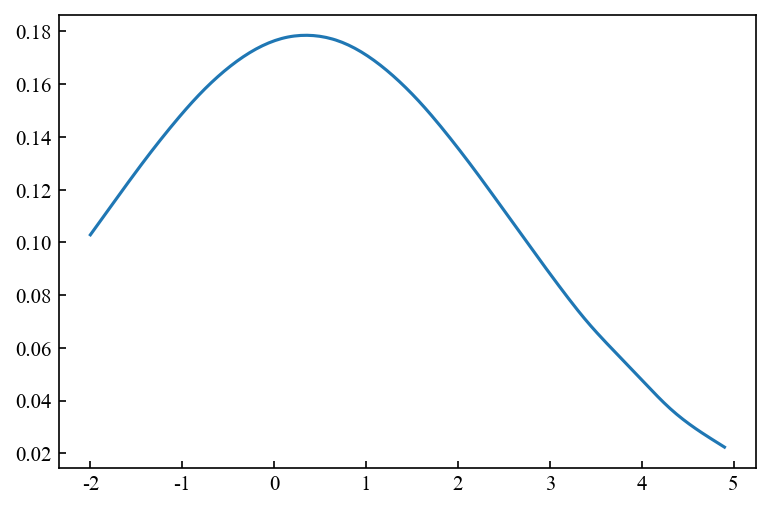

In [14]:
data = np.loadtxt('../../../hw/07第7章  插值与拟合习题解答/ti7_10.txt')
x0 = data[::2].flatten()
y0 = data[1::2].flatten()
f = interp1d(x0, y0, 'cubic')
x = np.linspace(-2, 4.9, 200)
y = f(x)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.plot(x, y)
fig.show()

In [15]:
n = len(x0)  #观测值的个数
RMSE = []; As = []  #剩余标准差和系数结果初始化
for m in range(1,5):
    A = np.polyfit(x0, y0, m)
    rmse = np.sqrt(sum((np.polyval(A,x0)-y0)**2)/(n-m-1))
    RMSE.append(rmse); As.append(A)
ind = np.argmin(RMSE) #求RMSE最小值的地址
print('拟合的多项式次数：',ind+1)
print(np.round(As[ind],4))

拟合的多项式次数： 4
[ 3.000e-04  1.000e-04 -1.520e-02  9.100e-03  1.751e-01]


m = 0.348283084469623
s = 2.234931715061521


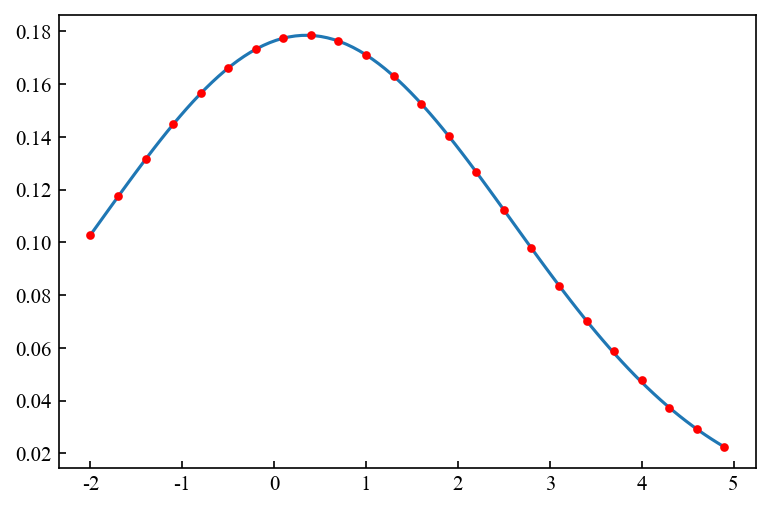

In [16]:
f = lambda x,m,s: 1/(np.sqrt(2*np.pi)*s)*np.exp(-(x-m)**2/(2*s**2))
A = curve_fit(f, x0, y0)[0]
m, s = A
print(f'{m = }\n{s = }')

x = np.linspace(x0.min(), x0.max(), 100)
m, s = A
y = f(x, m, s)
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.scatter(x0, y0, color='r', zorder=10, s=10)
fig.show()